### Importing libraries

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats

sns.set_theme(
    font = 'sans-serif',
)


In [11]:
pblocks = pd.read_csv('../B_hybrid_aln_gencode_v42/pblocks.tsv', sep='\t', index_col=['other', 'pblock_number'])

affected_length_ins_del = (pblocks['pblock_category'].isin({'INSERTION', 'DELETION'})) * pblocks['length_change'].abs()
affected_length_sub = (pblocks['pblock_category'] == 'SUBSTITUTION') * pblocks['aa_loss']
affected_length = affected_length_ins_del + affected_length_sub
pblocks['affected_length'] = affected_length
pblocks

anchor pblock_category  pblock_anchor_start  \
other      pblock_number                                                    
A1CF-201   0                A1CF-202        DELETION                  380   
A1CF-203   0                A1CF-202    SUBSTITUTION                    0   
           1                A1CF-202        DELETION                  380   
A1CF-204   0                A1CF-202        DELETION                  380   
A1CF-205   0                A1CF-202        DELETION                  380   
...                              ...             ...                  ...   
ZYG11A-202 0              ZYG11A-201        DELETION                    0   
ZYG11A-203 0              ZYG11A-201        DELETION                    0   
ZYG11B-202 0              ZYG11B-201    SUBSTITUTION                  565   
ZYX-203    0                 ZYX-201        DELETION                    0   
ZZZ3-201   0                ZZZ3-202    SUBSTITUTION                    0   

                          pblock_anchor_stop  pblock_other_start  \
other      pblock_number                                           
A1CF-201   0                             388                 380   
A1CF-203   0                              33                   0   
           1                             388                 388   
A1CF-204   0                             388                 380   
A1CF-205   0                             388                 380   
...                                      ...                 ...   
ZYG11A-202 0                             342                   0   
ZYG11A-203 0                             342                   0   
ZYG11B-202 0                             745                 565   
ZYX-203    0                             157                   0   
ZZZ3-201   0                             502                   0   

                          pblock_other_stop  aa_loss  aa_gain  length_change  \
other      pblock_number                                                       
A1CF-201   0                            380        8        0             -8   
A1CF-203   0                             41       33       41              8   
           1                            388        8        0             -8   
A1CF-204   0                            380        8        0             -8   
A1CF-205   0                            380        8        0             -8   
...                                     ...      ...      ...            ...   
ZYG11A-202 0                              0      342        0           -342   
ZYG11A-203 0                              0      342        0           -342   
ZYG11B-202 0                            567      180        2           -178   
ZYX-203    0                              0      157        0           -157   
ZZZ3-201   0                              8      502        8           -494   

                          anchor_length  ...  \
other      pblock_number                 ...   
A1CF-201   0                        595  ...   
A1CF-203   0                        595  ...   
           1                        595  ...   
A1CF-204   0                        595  ...   
A1CF-205   0                        595  ...   
...                                 ...  ...   
ZYG11A-202 0                        760  ...   
ZYG11A-203 0                        760  ...   
ZYG11B-202 0                        745  ...   
ZYX-203    0                        573  ...   
ZZZ3-201   0                        904  ...   

                                                               cblocks  \
other      pblock_number                                                 
A1CF-201   0                                             ('DELETION',)   
A1CF-203   0                             ('UNTRANSLATED', 'INSERTION')   
           1                                             ('DELETION',)   
A1CF-204   0                                             ('DELETION',)   
A1CF-205   0                     

### Statistics

In [12]:
pblocks['affected_length'].describe()

count    44326.000000
mean       151.307359
std        388.107169
min          1.000000
25%         21.000000
50%         49.000000
75%        128.000000
max      32222.000000
Name: affected_length, dtype: float64

### Distribution of number of altered regions per isoform

Text(0, 0.5, 'Number of alternative protein isoforms')

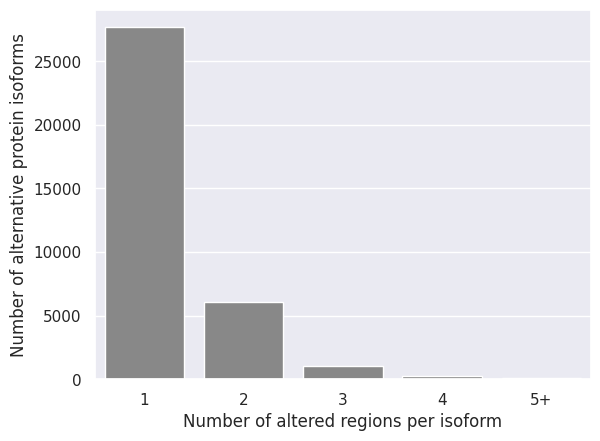

In [25]:
sns.countplot(
    x = pd.cut(
        pblocks.groupby(['anchor', 'other']).size(),
        bins = [1, 2, 3, 4, 5, 14],
        right = False,
        labels = ['1', '2', '3', '4', '5+']
    ),
    color = '#888888'
)
plt.xlabel('Number of altered regions per isoform')
plt.ylabel('Number of alternative protein isoforms')

### Plot 2: 

In [ ]:
q = 0.99

x = pblocks[pblocks['pblock_category']=='INSERTION']['length_change']
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

x = pblocks[pblocks['pblock_category']=='DELETION']['length_change'].abs()
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

x = pblocks[pblocks['pblock_category']=='SUBSTITUTION']['aa_loss']
sns.displot(x=x)
plt.xlim(0, x.quantile(q))

### Plot 3: 

In [ ]:
pblock_per_isoform=pblocks.groupby(['anchor', 'other'])
sns.scatterplot(data=pblocks[pblocks["pblock_category"]=="SUBSTITUTION"], x="aa_loss", y='aa_gain')

### Alt to pie chart

In [ ]:
sns.countplot(x=pblocks['pblock_category'])